In [1]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

2023-11-07 01:34:25.530609: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 01:34:25.530637: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 01:34:25.530660: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 01:34:25.538407: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:


(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
     


In [3]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

2023-11-07 01:34:46.617800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 01:34:46.621749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 01:34:46.621896: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:


BATCH_SIZE = 128
LATENT_DIM = 2
     


In [5]:
train_dataset = (
    dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [6]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [7]:
class Sampling(Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1])) 
     

In [8]:
encoder_inputs = Input(shape=(28,28,1))

x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)

mean = Dense(LATENT_DIM,)(x)
log_var = Dense(LATENT_DIM,)(x)

z = Sampling()([mean,log_var])

encoder_model = Model(encoder_inputs,[z,mean,log_var], name='encoder')
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

In [9]:

latent_inputs = Input(shape=(LATENT_DIM,))


x = Dense(7*7*64, activation='relu')(latent_inputs)
x = Reshape((7,7,64))(x)

x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)

decoder_output = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder_model = Model(latent_inputs,decoder_output,name='decoder')
decoder_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

In [10]:


vae_input = Input(shape=(28,28,1), name="vae_input")
z,_,_ = encoder_model(vae_input)
output = decoder_model(z)
vae = Model(vae_input, output, name="vae")
vae.summary()
     


Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vae_input (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 134165 (524.08 KB)
Trainable params: 134165 (524.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
for i in range(3):
  print(vae.layers[i])

In [12]:


OPTIMIZER = Adam(learning_rate = 1e-3)
EPOCHS = 20
     


In [13]:
def custom_loss(y_true,y_pred,mean,log_var):

  loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred), axis = (1,2)))

  loss_reg = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
  
  return loss_rec+tf.reduce_mean(tf.reduce_sum(loss_reg, axis=1))

In [14]:
@tf.function
def training_block(x_batch):
  with tf.GradientTape() as recorder:
    z,mean,log_var = encoder_model(x_batch)
    y_pred = decoder_model(z)
    y_true = x_batch
    loss = custom_loss(y_true,y_pred, mean, log_var)
  
  partial_derivatives = recorder.gradient(loss,vae.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, vae.trainable_weights))
  return loss

In [15]:
def neuralearn(epochs):
  for epoch in range(1,epochs+1):
    print('Training starts for epoch number {}'.format(epoch))

    for step, x_batch in enumerate(train_dataset):
      loss = training_block(x_batch)
    print('Training Loss is: ', loss)
  print('Training Complete!!!')

In [16]:
neuralearn(EPOCHS)

Training starts for epoch number 1


2023-11-07 01:40:20.883180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-07 01:40:21.887210: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6648d1e4e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-07 01:40:21.887232: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-11-07 01:40:21.892154: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-07 01:40:21.978191: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training Loss is:  tf.Tensor(194.85811, shape=(), dtype=float32)
Training starts for epoch number 2
Training Loss is:  tf.Tensor(183.4524, shape=(), dtype=float32)
Training starts for epoch number 3
Training Loss is:  tf.Tensor(191.26118, shape=(), dtype=float32)
Training starts for epoch number 4
Training Loss is:  tf.Tensor(189.31326, shape=(), dtype=float32)
Training starts for epoch number 5
Training Loss is:  tf.Tensor(174.38512, shape=(), dtype=float32)
Training starts for epoch number 6
Training Loss is:  tf.Tensor(182.58974, shape=(), dtype=float32)
Training starts for epoch number 7
Training Loss is:  tf.Tensor(181.43578, shape=(), dtype=float32)
Training starts for epoch number 8
Training Loss is:  tf.Tensor(174.74559, shape=(), dtype=float32)
Training starts for epoch number 9
Training Loss is:  tf.Tensor(178.5046, shape=(), dtype=float32)
Training starts for epoch number 10
Training Loss is:  tf.Tensor(176.94604, shape=(), dtype=float32)
Training starts for epoch number 11


In [17]:

scale=1
n=16
     

In [18]:
grid_x = np.linspace(-scale,scale,16)
grid_y = np.linspace(-scale,scale,16)

In [19]:
print(grid_x,grid_y)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ] [-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]


1/1 [==============================] - 0s 14ms/step


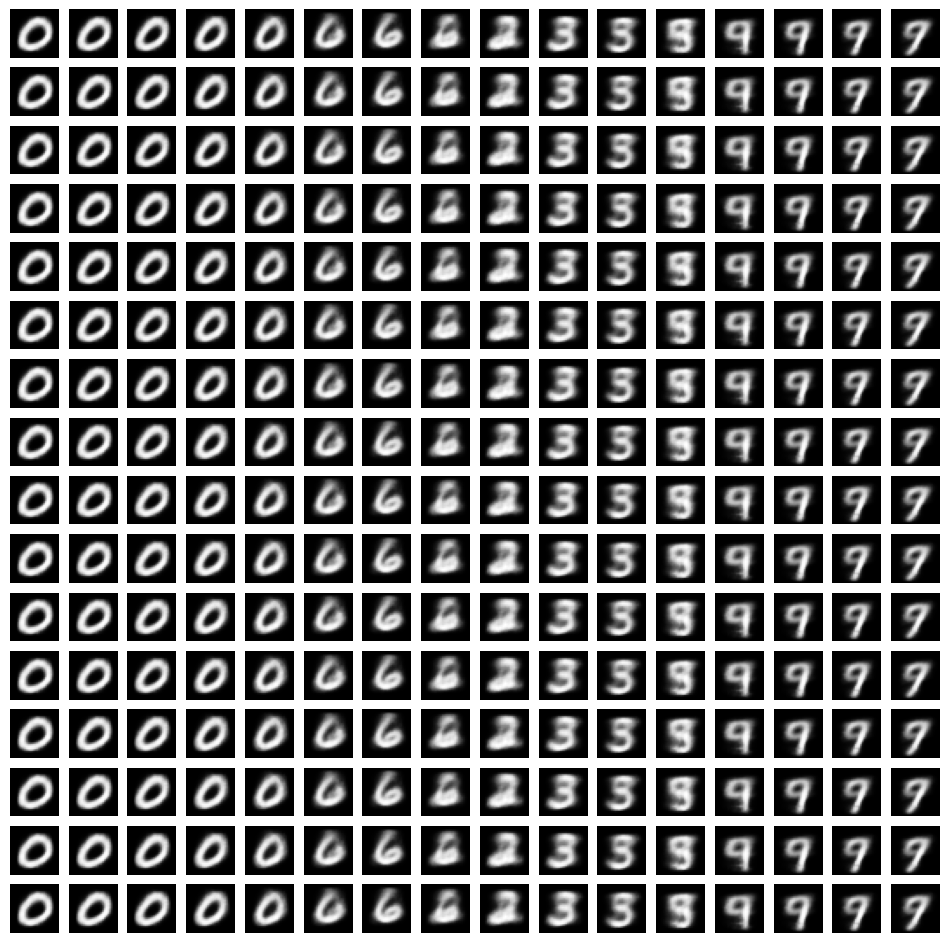

In [22]:
plt.figure(figsize=(12,12))
k=0
for i in grid_x:
  for j in grid_y:
    ax=plt.subplot(n,n,k+1)

    input=tf.constant([[i,j]])
    out=vae.layers[2].predict(input)[0][...,0]
    plt.imshow(out,cmap="Greys_r")
    plt.axis('off')
    k+=1

In [23]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
mnist_digits = np.expand_dims(x_train,-1).astype("float32") / 255

In [24]:
z,_,_=vae.layers[1].predict(x_train)

1875/1875 [==============================] - 3s 1ms/step


In [28]:
np.min(z[:, 0])

-127624.555

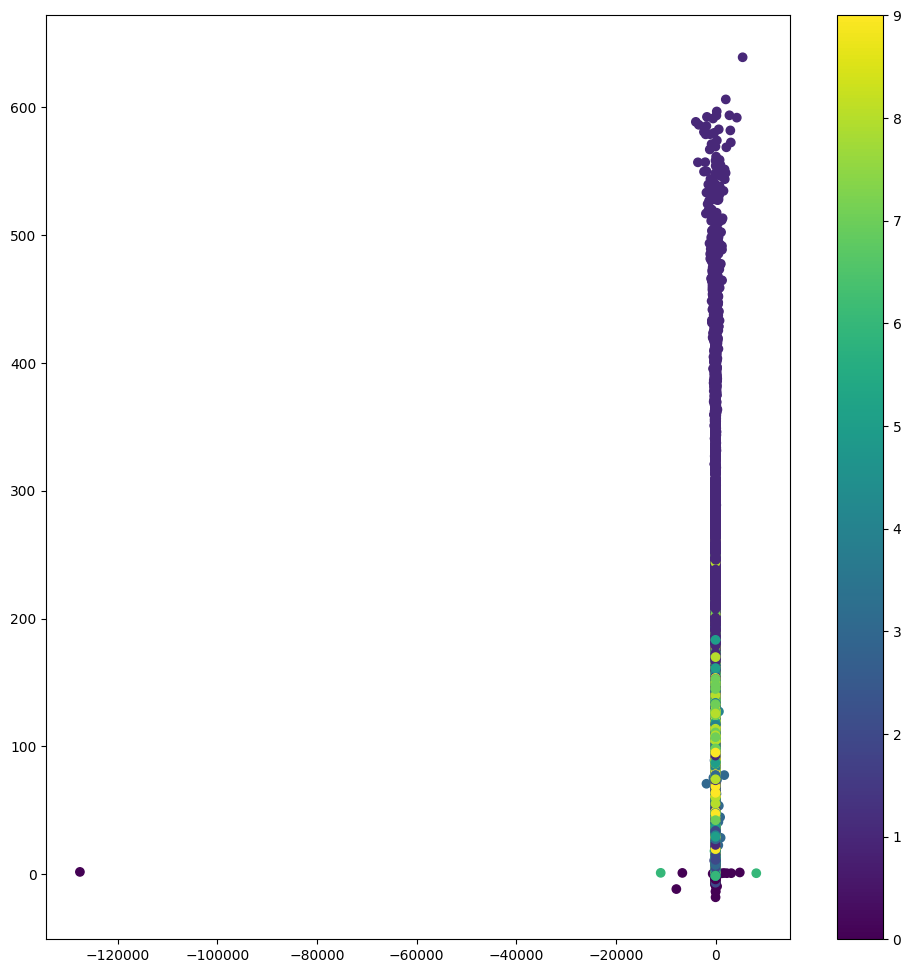

In [29]:
plt.figure(figsize=(12,12))
plt.scatter(z[:,0],z[:,1],c=y_train)
plt.colorbar()
plt.show()